# Waveform fitting

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob

(positive)>> Applying custom matplotlib settings.


## Preliminaries

In [2]:
#
datadir = '/Users/book/KOALA/puck/ll/data/version2/'
files = glob( datadir+'*.txt' )

#
data = []
for f in files:
    alert('Loading %s'%red(f))
    data.append(loadtxt(f).T)

(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q2_a10_a28_ph0_th90.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q8a04t30dPm3_T_96_360.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q2a04t60dPm1_T_96_408.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q2_a10_a28_ph0_th120.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q1a04t60_dPm1_T_96_552.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q4a04t30_T_96_360.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q8a04t120dPp1_T_96_360.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q4a04t150_T_96_360.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q4a04t60dPm1.5D_T_96_360.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q1a08t30dPm25_T_96_408.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/version2/q8a04t60D_dPm1.txt
(notebook)>> Loading /Users/book/KOALA/puck/ll/data/ve

In [42]:
# ?subplots

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(notebook)>> Done.


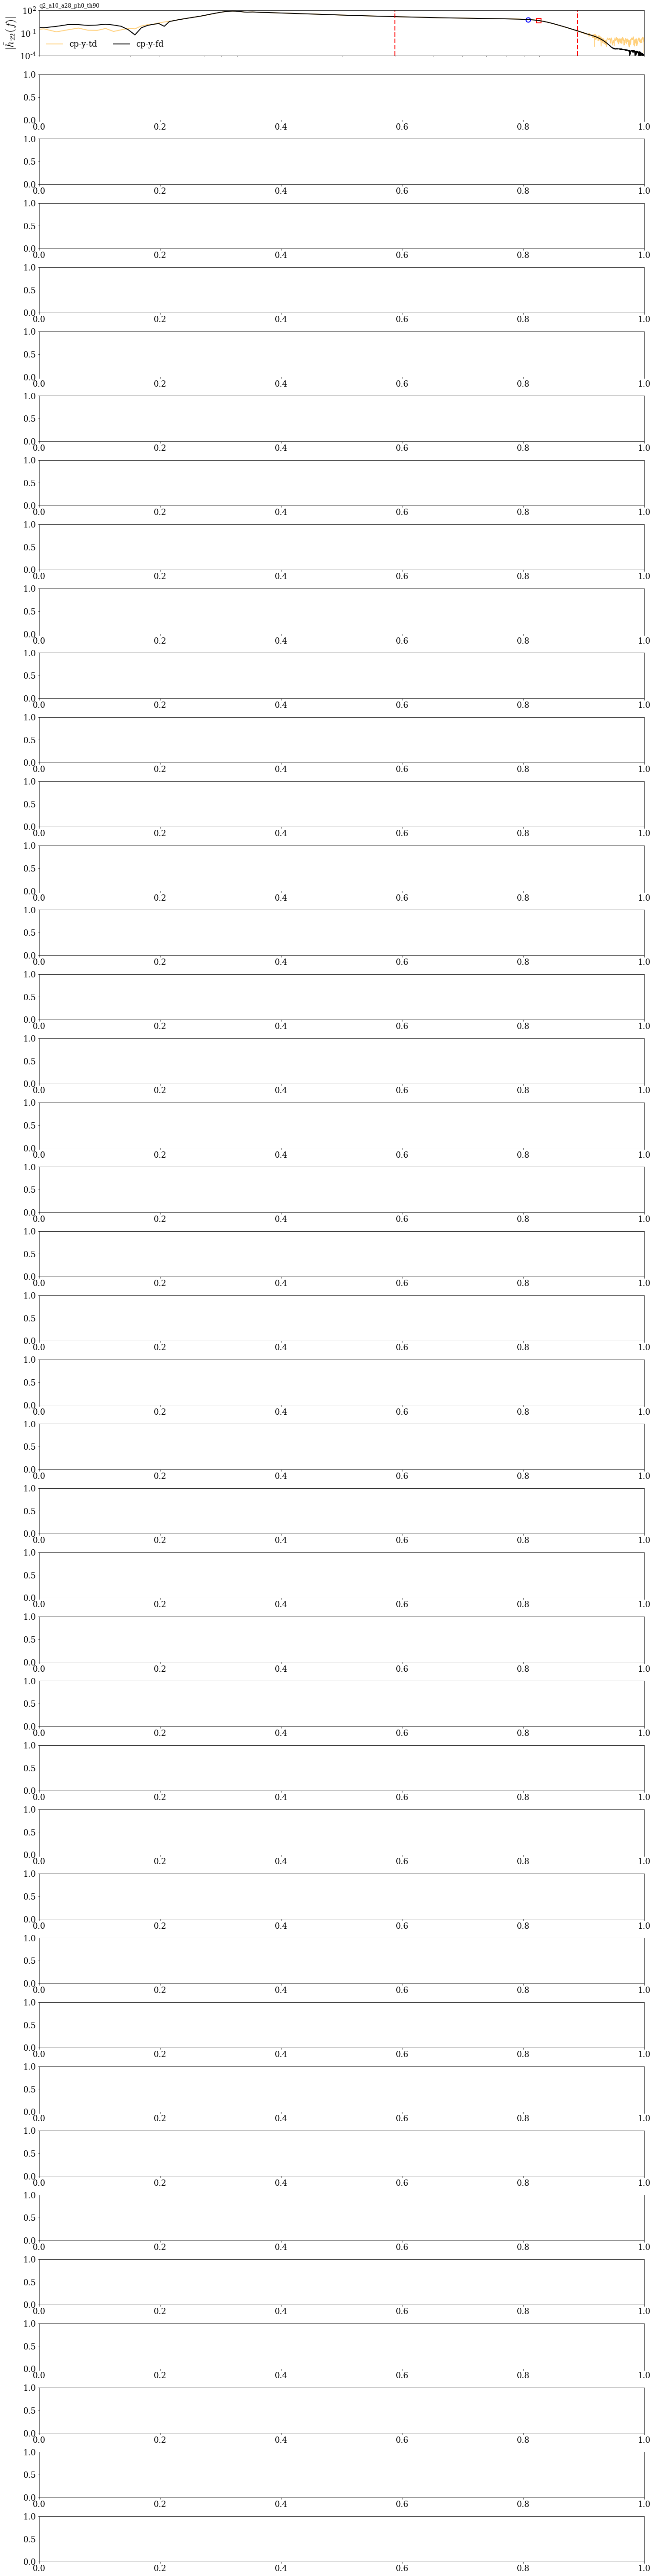

In [140]:


#
fig,ax = subplots( len(data), 1, figsize=5*figaspect(len(data)*0.618/4) )
ax = ax.flatten()

#
tight_layout(2,1,1)


#
for k in range(len(data)):

    #
    sca( ax[k] )

    #
    f,amp_td,amp_fd,dphi_td,dphi_fd = data[k]

    #
    fmin,fmax = 0.03, 0.12
    mask = (f>=fmin) & (f<=fmax)
    
    #
    x = log(f[mask])
    y = log(amp_fd[mask])
    knots,rom = romline( x,y,2 )
    plot( f[mask][knots[1]], amp_fd[mask][knots[1]], color='b', mfc='none', marker='o', ms=10, mew=2  )
    
    #
    x = log(f[mask])
    y = smooth(dphi_td[mask]).answer
    knot = argmin(y)
    plot( f[mask][knot], amp_fd[mask][knot], color='r', mfc='none', marker='s', ms=10, mew=2  )

    #
    plot( f, amp_td, alpha=0.5, color='orange', label='cp-y-td',lw=2 )
    plot( f, amp_fd, color='k', ls='-', label='cp-y-fd',lw=2 )

    #
    xlim(0.002,0.2)
    ylim(1e-4,1e2)

    #
    axvline( fmin, color='r', ls='--',lw=2 )
    axvline( fmax, color='r', ls='--',lw=2 )

    #
    xscale('log')
    yscale('log')
    
    #
    legend(ncol=2,loc=3)
    ylabel(r'$|\tilde{h}_{22}(f)|$')
    if k+1!=len(data):
        xticks([])
    else:
        xlabel('$fM$')
    title(files[k].split('/')[-1].split('.')[0],loc='left',size=12)
    
    #
    break

#
alert('Done.');
# savefig(datadir+'amp_fitting_region_diagnostic.pdf')

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.


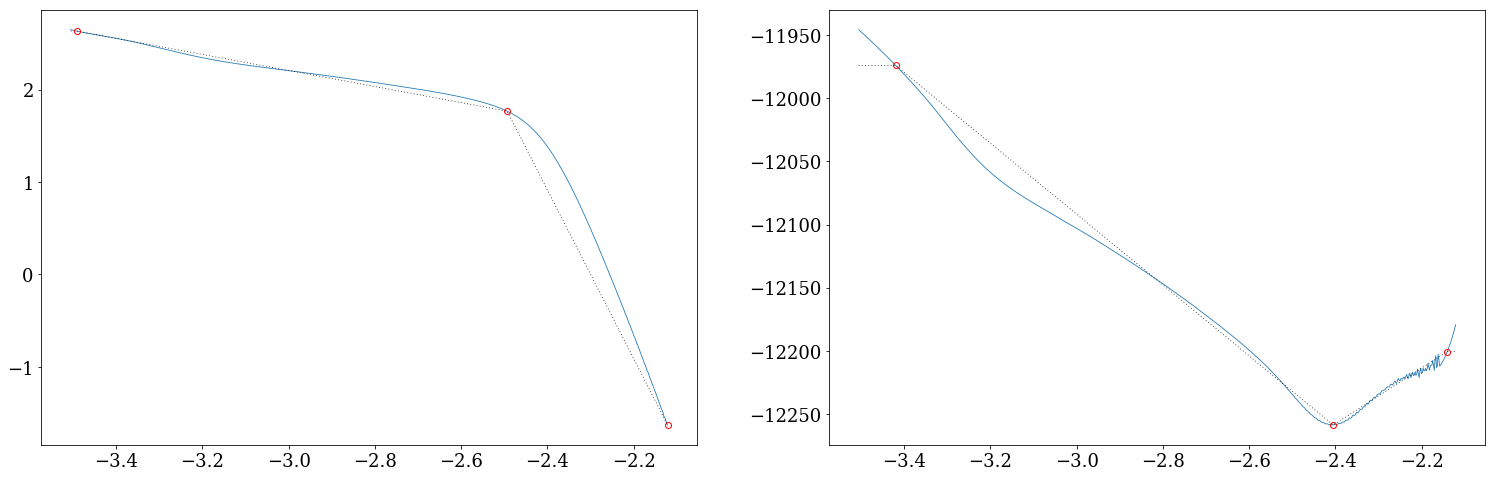

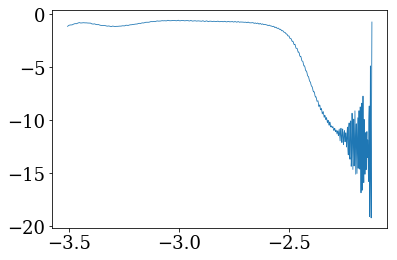

In [139]:
# f, amp_fd

#
figure( figsize=2*figaspect(0.618/2) )

subplot(1,2,1)

mask = (f>=fmin) & (f<=fmax)

x = log(f[mask])
y = log(amp_fd[mask])

#
knots,rom = romline( x,y,2 )

#
plot( x,y )
plot( x,rom(x),color='k',ls=':' )
plot( x[knots], y[knots], marker='o', color='r', mfc='none', ls='none' )

subplot(1,2,2)

# f, amp_fd

mask = (f>=fmin) & (f<=fmax)

x = log(f[mask])
y = smooth(dphi_fd[mask]).answer

#
knots,rom = romline( x,y,2 )

#
plot( x,y )
plot( x,rom(x),color='k',ls=':' )
plot( x[knots], y[knots], marker='o', color='r', mfc='none', ls='none' )

#
figure()

x = log(f[mask])
y = log(amp_fd[mask])

plot( x, spline_diff(x,y,3) )


In [64]:
??romline

Signature: romline(domain, range_, N, positive=True, keep_ends=False, verbose=False)
Source:   
def romline(  domain,           # Domain of Map
              range_,           # Range of Map
              N,                # Number of Lines to keep for final linear interpolator
              positive=True,   # Toggle to use positive greedy algorithm ( where rom points are added rather than removed )
              keep_ends = False,
              verbose = False ):

    # Use a linear interpolator, and a reverse greedy process
    from numpy import interp, linspace, array, inf, arange, mean, zeros, std, argmax, argmin
    linterp = lambda x,y: lambda newx: interp(newx,x,y)

    # Domain and range shorthand
    d = domain
    R = range_
    # Normalize Data
    R0,R1 = mean(R), std(R)
    r = (R-R0)/( R1 if abs(R1)!=0 else 1 )

    #
    if not positive:
        #
        done = False
        space = list(range( len(d)))
        raw_space = list(range( len(d)))
        err = lambda x: me